In [1]:
# Config notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('figure',figsize=(9,4.5))
rc('font',size=12)
rc('text',usetex=False)
rc('axes', facecolor = 'white')
rc('savefig', facecolor = 'white')

from qubicpack.qubicfp import qubicfp
import qubicpack as qp
from pysimulators import FitsArray
from qubicpack.utilities import TES_index, figure_window_title
from qubicpack.timeline import timeline_timeaxis
from qubicpack.utilities import qc_utc_date

import numpy as np
import glob
import os
import matplotlib.cm as cm
import warnings

# To fit===================================
# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

import pywt

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
#==========================================
#import string
import scipy.signal as scsig
from scipy import interpolate
from astropy.io import fits as pyfits

from sklearn.preprocessing import MinMaxScaler

import datetime as dt
import pickle
from importlib import reload
import datetime
import pandas as pd

# Superlocalmodule to create flags on the data
import DataFlagging as df

### Read data and store it in a dictionary

`ReadDataSet` is a method that allows you to simultaneously read data from different days, and different experiments. For this, it is necessary to tell it between which start and end date to search (`datestart`, `dateend` respectively), and finally the keyword associated with the experiment(s) to be read (from the `eLog`). The dictionary returns not only the focal plane objects (`qubicfp`) associated with each data set (day+experiment) but also the names of the files it read, and the days read. The output format is:

```
DataContainer = {'YYYY-MM-DD0': [qfp00, qfp01, qfp02,..., qfp0N],              
                  'YYYY-MM-DD1': [qfp10, afp11, qfp12,..., qfp1M],
                  'fnameYYY-MM-DD0: ['/sps/qubic/Data/Calib-TD/2022-08-24/2022-08-24_15.11.42__Responsivity-1layer', ...]},
                  'fnameYYY-MM-DD0: ['/sps/qubic/Data/Calib-TD/2022-08-26/2022-08-26_14.20.03__Responsivity-1layer-10sec-2.0V', ...]},
                  'kwdays': ['YYYY-MM-DD0', 'YYYY-MM-DD1']}
```

In [3]:
reload(df)
DataContainer = df.ReadDataSet(datestart = '23-08-2022',
                              dateend = '24-08-2022',
                              keywords = ['Responsivity'],
                            verbose = True)

Days to read data ['2022-08-23', '2022-08-24']
0
day 2022-08-24 - has 8 files of Responsivity-1layer test
ASIC1     Observation date: 2022-08-24 15:11:42.116000
ASIC1 Observation end date: 2022-08-24 15:14:06.118000
ASIC2     Observation date: 2022-08-24 15:11:42.117000
ASIC2 Observation end date: 2022-08-24 15:14:06.118000
No hornswitch data found in directory: /sps/qubic/Data/Calib-TD/hornswitch
Please give a valid asic number
No previously saved filter information: QUBIC_TES_ASIC1_20220824T151142UTC.filter.pickle
No previously saved filter information: QUBIC_TES_ASIC2_20220824T151142UTC.filter.pickle
No PPS in EXTERN_HK
No PPS.  Using timestamp instead
TES temperature varies between 321.7mK and 322.1mK during the measurement
Each data array has approximatelly 4.577760000000001e-05 MB
1
day 2022-08-24 - has 8 files of Responsivity-1layer-10sec test
ASIC1     Observation date: 2022-08-24 15:15:00.456000
ASIC1 Observation end date: 2022-08-24 15:15:07.317000
ASIC2     Observation date:

### Flag data (300mK, 1K stages)

To flag the data we will use JCh's way. 

1st) Get the time in regular time grid using `.tod()` method: $regtime = DataContainer[day][indx].tod()[0]$, where day is in YYYY-MM-DD format and $indx$ is an index of one of the elements of the list (a qubic focal plane - qfp).

2nd) Get the housekeeping time and data (here the procedure for another category will change since it will be used a TES). **This data is the one that will be flagged**: $rawtime, rawdata$.

3rd) Flag the data 

4th) Interpolate flagged data using the regular time grid.

In [4]:
DataContainer

{'2022-08-24': [<qubicpack.qubicfp.qubicfp at 0x7ffb48eb86a0>,
 'fnames2022-08-24': ['/sps/qubic/Data/Calib-TD/2022-08-24/2022-08-24_15.11.42__Responsivity-1layer',
  '/sps/qubic/Data/Calib-TD/2022-08-24/2022-08-24_15.15.00__Responsivity-1layer-10sec',
  '/sps/qubic/Data/Calib-TD/2022-08-24/2022-08-24_15.15.07__Responsivity-1layer-10sec',
  '/sps/qubic/Data/Calib-TD/2022-08-24/2022-08-24_15.20.14__Responsivity-2layer-10sec',
  '/sps/qubic/Data/Calib-TD/2022-08-24/2022-08-24_15.32.18__Responsivity-1layer-10sec-2.5V',
  '/sps/qubic/Data/Calib-TD/2022-08-24/2022-08-24_15.35.31__Responsivity-2layer-10sec-2.5V',
  '/sps/qubic/Data/Calib-TD/2022-08-24/2022-08-24_15.40.43__Responsivity-1layer-10sec-3.0V',
  '/sps/qubic/Data/Calib-TD/2022-08-24/2022-08-24_15.44.58__Responsivity-2layer-10sec-3.0V'],
 'kwdays': ['2022-08-24']}

In [11]:
reload(df)

# For one focal plane (qfp)
ds = df.FlagData(DataContainer['2022-08-24'][3])

# Flag temperature
flags300mK = ds.flag_bathtemp()
# Flag rising temperature
flags300mK_rise = ds.flag_bathtemp_rise()

# Sum the two interpolated flags in a single array
totalflags_300mK = flags300mK['flag'] + flags300mK_rise['flag']

suggest nsamples=22272 which is  2^8*3*29


### Visualization (300mK stage flags)

suggest nsamples=26112 which is  2^9*3*17


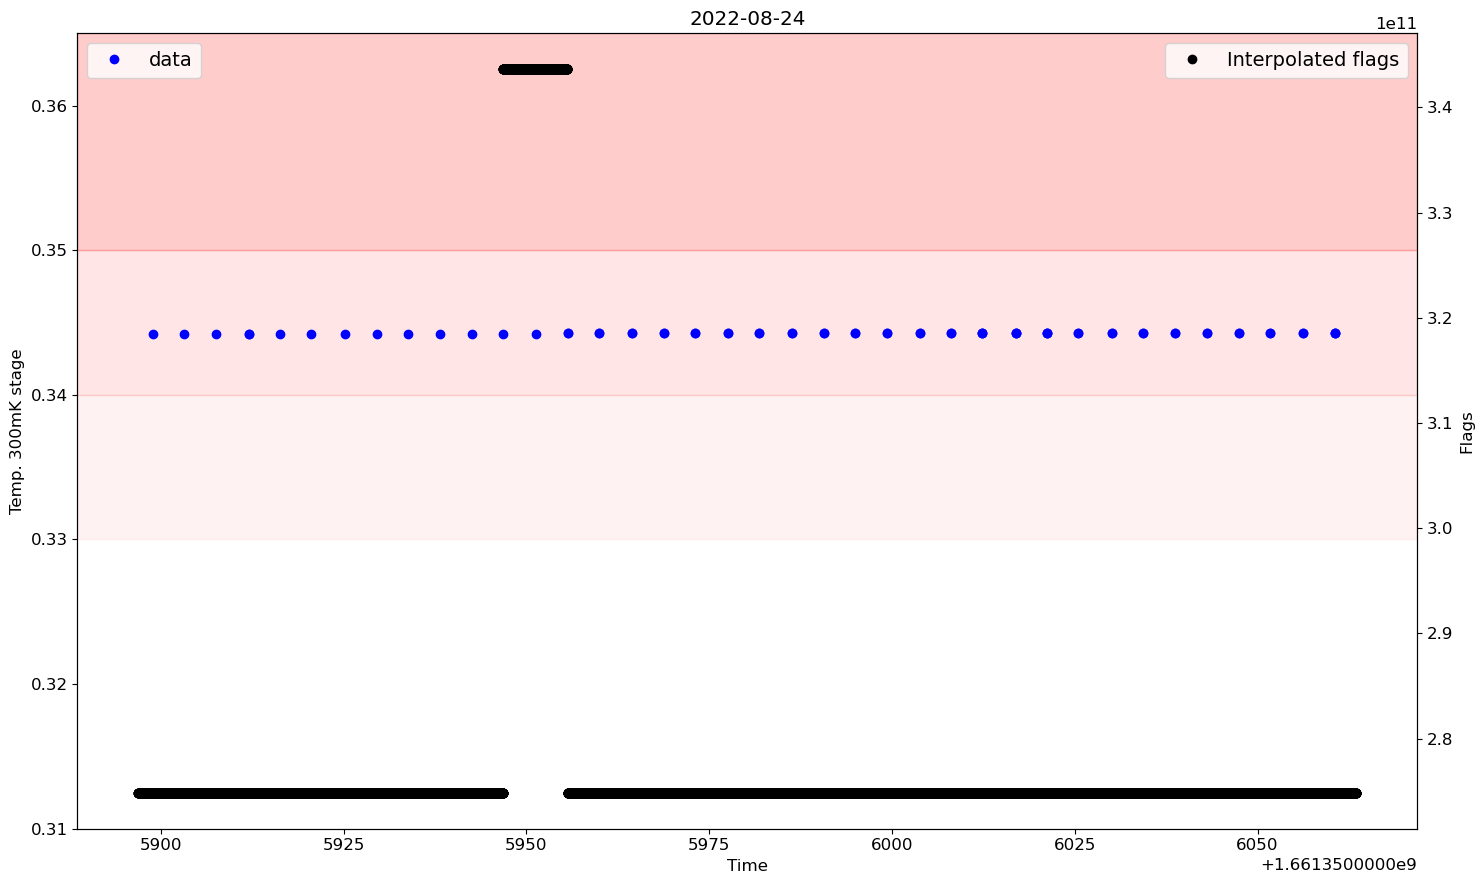

In [26]:
fig = plt.figure(figsize = (15,9))

testime = np.copy(ds.data.get_hk(data='RaspberryDate',hk='EXTERN_HK'))
testdata300mK = np.copy(ds.data.get_hk('AVS47_1_CH6'))
regtime = ds.data.tod()[0]

auxax = plt.subplot(1, 1, 1)
auxax.plot(testime, testdata300mK, 'ob', label = 'data')
auxax.set_ylim(0.310,0.365)
auxax.axhspan(0.330,0.340, color = 'r', alpha = 0.05)
auxax.axhspan(0.340,0.350, color = 'r', alpha = 0.1)
auxax.axhspan(0.350,0.365, color = 'r', alpha = 0.2)

auxax.set_xlabel('Time')
auxax.set_ylabel('Temp. 300mK stage')
auxax.set_title('{}'.format('2022-08-24'))
auxax.legend(loc = 'upper left', fontsize = 14)

ax = auxax.twinx()
#ax.plot(testime, flags300mK['flag_raw'] + flags300mK_rise['flag_raw'], marker = 'o', color = 'k', linestyle = '', 
ax.plot(regtime, totalflags_300mK, marker = 'o', color = 'k', linestyle = '', 
        label = 'Interpolated flags')
ax.set_ylabel('Flags')

ax.legend(loc = 'upper right', fontsize = 14)

plt.tight_layout()

### Mask

In [36]:
# len(interp1d(testime, testdata300mK, kind='previous', 
#          fill_value='extrapolate')(ds.regtime)), len(interp1d(testime, testdata300mK, kind='next', 
#                                                fill_value='extrapolate')(ds.regtime))

In [38]:
maskflag300mK = df.FlagToMask()
# for ikey in maskflag300mK.FullFlags.keys():
#     print(ikey)

maskdict = {'saturation': False, 'Tbath above 340mK': True, '1K above 1.2K': True, 
            'Tbath rising': True, '1K rising': True}

mask300mK = maskflag300mK(totalflags_300mK, maskdict)

# Interpolate data 
# data_interp = np.max(np.array([interp1d(testime, testdata300mK, kind='previous', 
#                                                fill_value='extrapolate')(ds.regtime), 
#                                 interp1d(testime, testdata300mK, kind='next', 
#                                                fill_value='extrapolate')(ds.regtime)], dtype = np.int64), axis=0)
#plt.plot(testime-testime[0], testdata300mK, 'ok', alpha = 0.3)
#plt.plot(ds.regtime[mask300mK]-ds.regtime[mask300mK][0], data_interp[mask300mK], 'og')
print(len(mask300mK), sum(mask300mK))

26112 0


### 1K Stage

In [20]:
reload(df)

# For one focal plane (qfp)
ds = df.FlagData(DataContainer['2022-08-24'][0])

# Flag temperature
flags1K = ds.flag_1Ktemp()
# Flag rising temperature
flags1K_rise = ds.flag_1Ktemp_rise()

# Sum the two interpolated flags in a single array
totalflags_1K = flags1K['flag'] + flags1K_rise['flag']

suggest nsamples=22528 which is  2^11*11


### Visualization (1K stage flags)

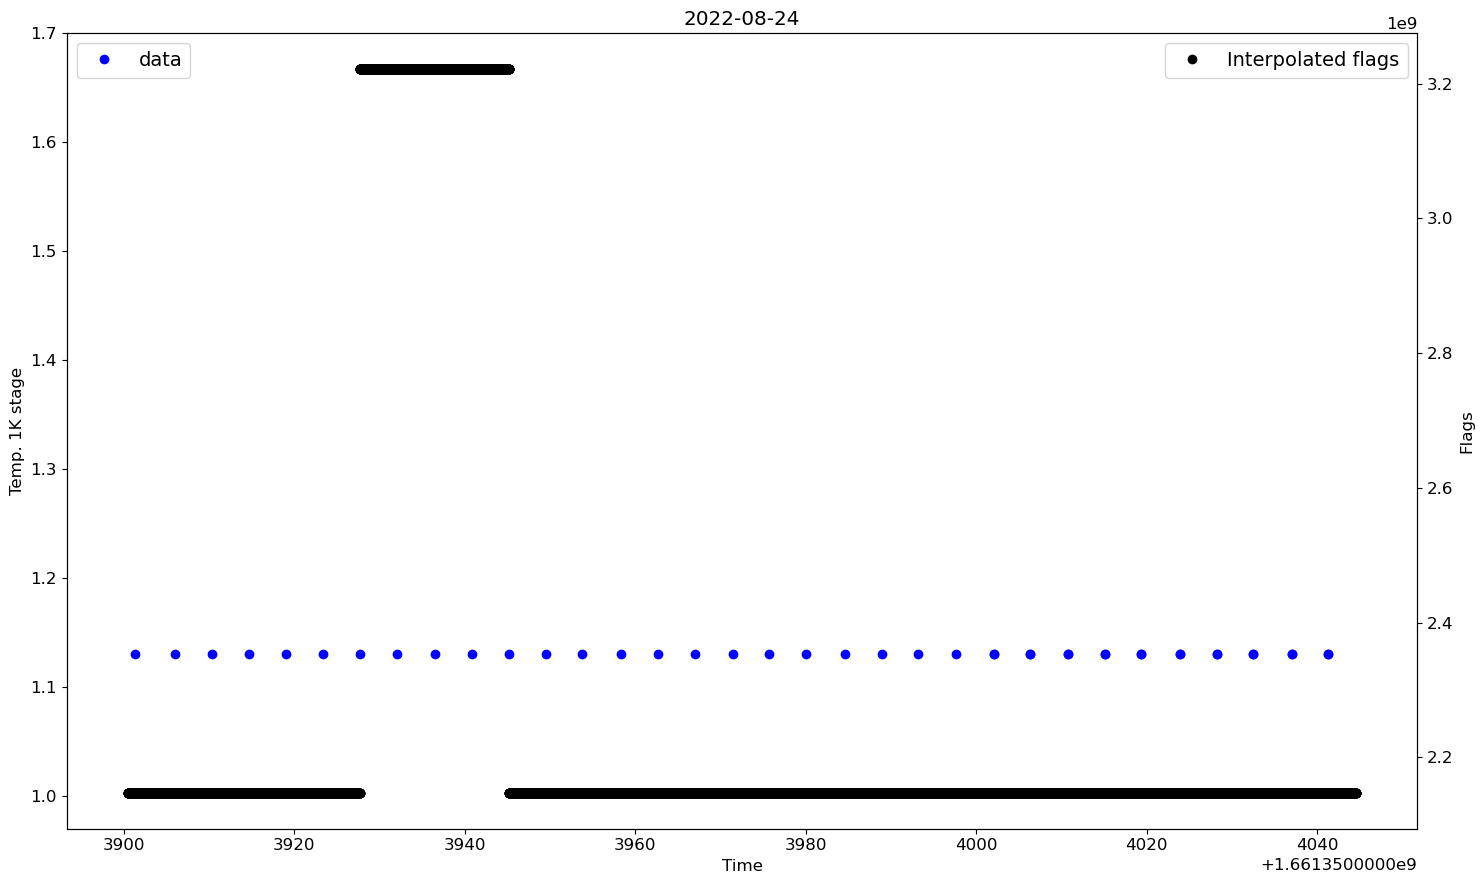

In [21]:
testime = np.copy(ds.data.get_hk(data='RaspberryDate',hk='EXTERN_HK'))
testdata1K = np.copy(ds.data.get_hk('AVS47_1_ch1'))

fig = plt.figure(figsize = (15,9))

auxax = plt.subplot(1, 1, 1)
auxax.plot(testime, testdata1K, 'ob', label = 'data')
auxax.set_ylim(0.97, 1.7)

auxax.set_xlabel('Time')
auxax.set_ylabel(r'Temp. 1K stage')

auxax.set_title('{}'.format('2022-08-24'))
auxax.legend(loc = 'upper left', fontsize = 14)

ax = auxax.twinx()
ax.plot(ds.regtime, totalflags_1K, marker = 'o', 
        color = 'k', linestyle = '', 
        label = 'Interpolated flags')
ax.set_ylabel('Flags')
ax.legend(loc = 'upper right', fontsize = 14)

plt.tight_layout()

###  Do the same looping over one day and accounting temperature flags

In [22]:
DataContainer['kwdays']

['2022-08-24']

suggest nsamples=22528 which is  2^11*11
suggest nsamples=22528 which is  2^11*11
suggest nsamples=1079 which is  2^0*13*83
suggest nsamples=1079 which is  2^0*13*83
suggest nsamples=24832 which is  2^8*97
suggest nsamples=24832 which is  2^8*97
suggest nsamples=22272 which is  2^8*3*29
suggest nsamples=22272 which is  2^8*3*29
suggest nsamples=23104 which is  2^6*19
suggest nsamples=23104 which is  2^6*19
suggest nsamples=19712 which is  2^8*7*11
suggest nsamples=19712 which is  2^8*7*11
suggest nsamples=31488 which is  2^8*3*41
suggest nsamples=31488 which is  2^8*3*41
suggest nsamples=26112 which is  2^9*3*17
suggest nsamples=26112 which is  2^9*3*17


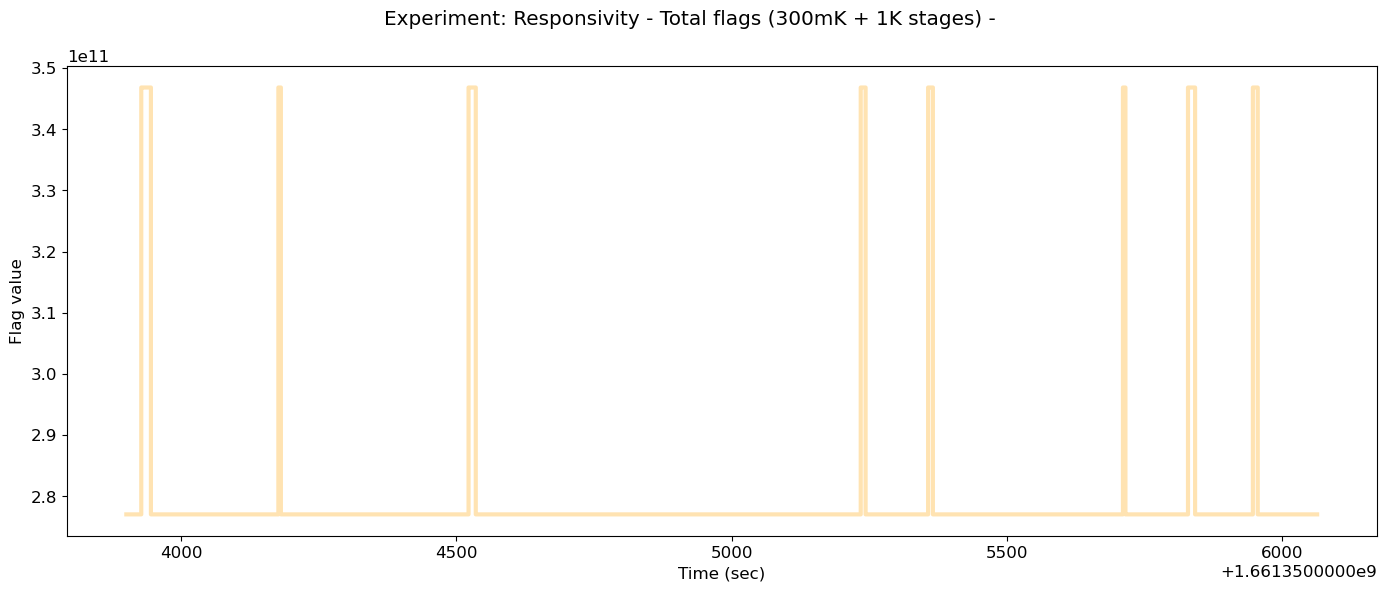

In [23]:
# Flag and score computation

iday = DataContainer['kwdays'][0]

# 'AVS47_1_CH6' 300mK or 'AVS47_1_ch1' 1K stage
bothlabels = ['AVS47_1_CH6', 'AVS47_1_ch1']
bothlabelw = ['300mKstage', '1Kstage']

fig = plt.figure(figsize = (14,6))
plt.suptitle('Experiment: {} - Total flags (300mK + 1K stages) - '.format('Responsivity'))

totalflags = []
totalflags_interp = []
totaltime_interp = []
rawtime = []

colors2 = cm.get_cmap('rainbow', len(DataContainer[iday]))(range(len(DataContainer[iday])))

for indx in range(len(DataContainer[iday])):
    # Regular time (used to interpolate flags)
    
    # Data
    ds = df.FlagData(DataContainer[iday][indx])

    regtime = ds.data.tod()[0]    
    totaltime_interp.append(regtime)

    testime = np.copy(ds.data.get_hk(data='RaspberryDate',hk='EXTERN_HK'))
    rawtime.append(testime)
    
    for label in bothlabels: # loop in channels
        testdata = np.copy(ds.data.get_hk(label))        
        
        # 1st/2nd Step
        if label == 'AVS47_1_CH6':
            # Flag temperature
            flags300mK = ds.flag_bathtemp()
            # Flag rising temperature
            flags300mK_rise = ds.flag_bathtemp_rise()

            # Sum the two interpolated flags in a single array
            totalflags_300mK = flags300mK['flag'] + flags300mK_rise['flag']
            
        elif label == 'AVS47_1_ch1':
            # Flag temperature
            flags1K = ds.flag_1Ktemp()
            # Flag rising temperature
            flags1K_rise = ds.flag_1Ktemp_rise()

            # Sum the two interpolated flags in a single array
            totalflags_1K = flags1K['flag'] + flags1K_rise['flag']
    
    totalflags.append(totalflags_300mK + totalflags_1K)
    #totalflags_interp.append(totalflags_300mK_interp + totalflags_1K_interp)

#print(np.shape(rawtime), np.shape(totalflags), np.shape(totaltime_interp), np.shape(totalflags_interp))
plt.ylabel('Flag value')
plt.step(np.concatenate(totaltime_interp), np.concatenate(totalflags), color = 'orange', 
         alpha =0.3, label='no interp' if indx ==0 else ' ', linestyle = '-', lw = 3)
plt.xlabel('Time (sec)')

fig.tight_layout(pad=1.0)
#plt.savefig('Flags_Total300mK1K_{}.png'.format(iday))